In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks-2024':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import glob, re, pprint, random
from datetime import datetime
import pprint

from scipy.stats import pearsonr, ttest_ind
from scipy.signal import savgol_filter
from scipy import interpolate

from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt

from src.formation import FormationCell
from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 14
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

GREY = (0.9, 0.9, 0.9)

In [3]:
cell_dict = dict()
cellid_list = np.arange(1, 41)
cellid_fast = []

for cellid in cellid_list:

    if cellid == 9:
        continue

    cell_dict[cellid] = FormationCell(cellid)

    if not cell_dict[cellid].is_baseline_formation():
        cellid_fast.append(cellid)

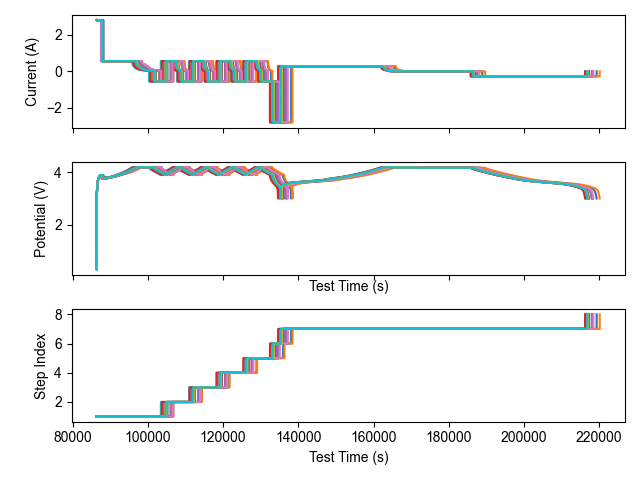

In [22]:
%matplotlib widget
fig, axs = plt.subplots(3, 1, sharex=True)

for cellid in cellid_fast:

    df_form = cell_dict[cellid].get_formation_data()

    # Skip data from the initial rest step
    df_form = df_form[df_form['Test Time (s)'] > 86400]

    # First subplot
    axs[0].plot(df_form['Test Time (s)'], df_form['Current (A)'])
    axs[0].set_ylabel('Current (A)')

    # Second subplot
    axs[1].plot(df_form['Test Time (s)'], df_form['Potential (V)'])
    axs[1].set_xlabel('Test Time (s)')
    axs[1].set_ylabel('Potential (V)')

    axs[2].plot(df_form['Test Time (s)'], df_form['Cycle Number'])
    axs[2].set_xlabel('Test Time (s)')
    axs[2].set_ylabel('Step Index')

plt.show()

In [21]:
df_form

,Datapoint Number,Test Time (s),Cycle Number,Current (A),Potential (V),Step Index,Step Time (s),Charge Capacity (Ah),Discharge Capacity (Ah),Charge Energy (Wh),...,[Maccor] VAR 14,[Maccor] VAR 15,[Maccor] VAR 2,[Maccor] VAR 3,[Maccor] VAR 4,[Maccor] VAR 5,[Maccor] VAR 6,[Maccor] VAR 7,[Maccor] VAR 8,[Maccor] VAR 9
51,52,86400.04,1,2.801862,0.341421,2,0.04,0.000030,0.000000,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,53,86400.20,1,2.799573,1.052796,2,0.20,0.000155,0.000000,0.000108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,54,86400.29,1,2.800031,1.280613,2,0.29,0.000225,0.000000,0.000194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,55,86400.38,1,2.800183,1.451438,2,0.38,0.000295,0.000000,0.000292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,56,86400.47,1,2.799878,1.602197,2,0.47,0.000365,0.000000,0.000401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,2262,219342.71,7,-0.279850,3.010376,14,30425.74,2.171559,2.365987,8.255327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2262,2263,219348.05,7,-0.279698,3.005264,14,30431.08,2.171559,2.366402,8.255327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2263,2264,219353.17,7,-0.279850,3.000153,14,30436.20,2.171559,2.366801,8.255327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2264,2265,219353.29,7,-0.280003,3.000000,14,30436.32,2.171559,2.366810,8.255327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


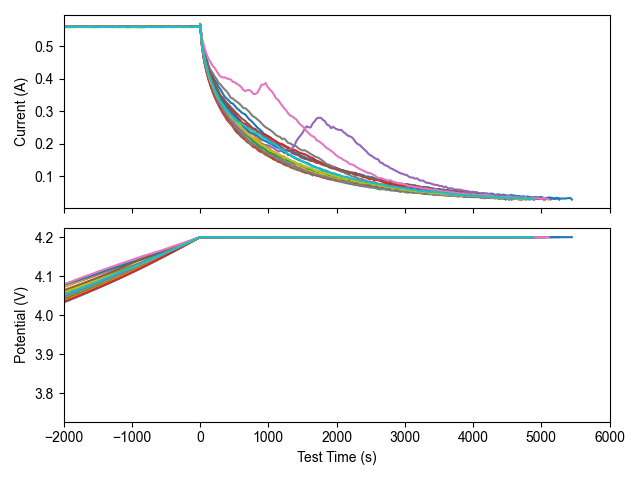

In [24]:
%matplotlib widget
fig, axs = plt.subplots(2, 1, sharex=True)

for cellid in cellid_fast:

    df_form = cell_dict[cellid].get_formation_data()

    # Skip data from the initial rest step
    df_form_cccv = df_form[(df_form['Step Index'] >= 4) &
                           (df_form['Step Index'] <= 5) &
                           (df_form['Cycle Number'] == 1)]

    df_form_cv = df_form[df_form['Step Index'] == 5]
    tt = df_form_cccv['Test Time (s)'] - df_form_cv['Test Time (s)'].min()

    # First subplot
    axs[0].plot(tt, df_form_cccv['Current (A)'])
    axs[0].set_ylabel('Current (A)')

    # Second subplot
    axs[1].plot(tt, df_form_cccv['Potential (V)'])
    axs[1].set_xlabel('Test Time (s)')
    axs[1].set_ylabel('Potential (V)')

axs[0].set_xlim((-2000, 6000))
plt.show()